In [24]:
# import libraries
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [19]:
# get current working directory with os.getcwd()
os.getcwd()

#os.chdir('../')

'/Users/finn/Desktop/intro_comp/Groupwork'

In [202]:
def read_training_data(data_directory, split, classes, img_size):
    split_data = [[], [], []]
    classes_data = [[], [], []]

    for spl_index, spl in enumerate(split):
        for cla_index, cla in enumerate(classes):
            path = os.path.join(data_directory, spl, cla)
            class_num = classes.index(cla)
            for img in os.listdir(path):
                img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
                img_array = cv.resize(img_array, (img_size, img_size))
                split_data[spl_index].append(img_array)
                classes_data[spl_index].append(class_num)
            print(path, '(read', len(classes_data[spl_index]) ,'images)')
    return split_data, classes_data

In [294]:
def select_random_image(split_data, classes_data, split_set):
    rand_img_num = np.random.randint(0, len(split_data[split_set]))
    img = split_data[split_set][rand_img_num]
    img_label = classes_data[split_set][rand_img_num]
    return img, img_label, rand_img_num

In [211]:
def show_random_image(classes, classes_data, img, rand_img_num, split_set=0):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(classes[classes_data[split_set][rand_img_num]])
    plt.show()

In [241]:
class conv_layer:
    """
    Convolution layer expects an input dimension (in_dim) of shape (h, w, d), where h and w
    are hight and width of images and d the number of dimensions. 

    Currently there is no padding or stride configuration. The layer operates with no paddling 
    and a stride of one.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    conv_size -> tuple of shape (h, w) -> size of convolution kernel
    kernel_num -> int -> number of kernels
    """
    def __init__(self, in_dim, conv_size=(3,3), kernel_num=4, debug = False):
        self.kernel_num = kernel_num
        self.conv_size = conv_size
        self.conv_kernels = [None] * self.kernel_num

        for i in range(0, self.kernel_num):
            if debug:
                self.conv_kernels[i] = self.debug_conv((conv_size[0], conv_size[1], in_dim[2]))
            else:
                self.conv_kernels[i] = np.random.uniform(-1,1,(conv_size[0], conv_size[1], in_dim[2]))

        self.in_dim = in_dim
        self.out_dim = (self.in_dim[0] - (conv_size[0] - 1), self.in_dim[1] - (self.conv_size[1] - 1), self.kernel_num)
    
    '''
    perform a forward convolution on the specified image.

    img -> np.array of shape (h,w,d)
    
    ret:
    out_img -> np.array of shape (h,w,d)
    '''
    def forward(self, img):
        out_img = np.zeros(self.out_dim)
        for k in range(0, self.kernel_num):
            for h in range(0, self.out_dim[0]):
                for w in range(0, self.out_dim[1]):
                    out_img[h, w, k] = np.sum(img[h:h+self.conv_size[0], w:w+self.conv_size[1],:] * self.conv_kernels[k])
        return out_img
    
    '''
    get out put dimension of this network layer

    ret:
    out_dim -> tuple of shape (h,w,d)
    '''
    def get_out_dim(self):
        return self.out_dim
    
    def debug_conv(self, size):
        kernel = np.zeros(size)
        for i in range(0, size[0],2):
            kernel[i,:,:] = 1
        return kernel

In [242]:
class max_pooling_layer:
    """
    Max pooling layer expects an input dimension (in_dim) of shape (h, w, d), where h and w
    are hight and width of images and d the number of dimensions. 
    
    Currently there is no padding or stride configuration. The layer operates with no paddling 
    and a stride of one.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    pooling_size -> tuple of shape (h, w) -> size of pooling filter
    """
    def __init__(self, in_dim, pooling_size=(3,3)):
        self.pooling_size = pooling_size
        self.in_dim = in_dim
        h_overflow = 1 if self.in_dim[0] % self.pooling_size[0] > 0 else 0
        w_overflow = 1 if self.in_dim[1] % self.pooling_size[1] > 0 else 0
        self.out_dim = (int(self.in_dim[0] / self.pooling_size[0]) + h_overflow, int(self.in_dim[0] / self.pooling_size[0]) + w_overflow, self.in_dim[2])
        
    '''
    perform forward pooling on the specified image.

    img -> np.array of shape (h,w,d)
    
    ret:
    out_img -> np.array of shape (h,w,d)
    '''
    def forward(self, img):
        out_img = np.empty(self.out_dim)
        h_overflow = True if self.in_dim[0] / self.pooling_size[0] - self.out_dim[0] > 0 else False
        w_overflow = True if self.in_dim[1] / self.pooling_size[1] - self.out_dim[1] > 0 else False
        for d in range(0, self.out_dim[2]):
            for w in range(0, self.out_dim[0]):
                for h in range(0, self.out_dim[1]):
                    pool_size_h = self.pooling_size[0]
                    pool_size_w = self.pooling_size[1]
                    if h_overflow and h == (self.out_dim[0]-1):
                        pool_size_h = self.in_dim[0] % self.pooling_size[0]
                    if h_overflow and h == (self.out_dim[0]-1):
                        pool_size_w = self.in_dim[1] % self.pooling_size[1]

                    out_img[h,w,d] = np.max(img[h*pool_size_h:h*pool_size_h+pool_size_h, w*pool_size_w:w*pool_size_w+pool_size_w,d])
        return out_img
    '''
    get out put dimension of this network layer

    ret:
    out_dim -> tuple of shape (h,w,d)
    '''
    def get_out_dim(self):
        return self.out_dim

In [243]:
# currently only ReLU activation function hardcoded
class activation_layer:
    '''
    ReLU activation layer performs a ReLU function on each element in the input image. 
    This means it basically set everything to zero that is smaller then zero.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    '''
    def __init__(self, in_dim,):
        self.in_dim = in_dim

    def forward(self, img):
        out_img = np.stack(np.vectorize(self.relu)(img), axis=0)
        return out_img

    def relu(self, el):
        return(np.maximum(0, el))

In [333]:
class fully_connected_layer:
    '''
    The fully connected layer transforms the input into a fully connected network
    with an output vector of out_dim.

    in_dim -> tuple of shape (h,w,d) -> input image dimensions 
    out_dim -> int -> defines the number of output nodes
    '''
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        w_dim = 1
        for d in in_dim:
            w_dim = w_dim * d
        self.weights = np.ones((self.out_dim, w_dim))
    
    
    def forward(self, img):
        out_vec = np.zeros(self.out_dim)
        img_vec = img.flatten()

        for i in range(0, self.out_dim):
            out_vec[i] = np.sum(img_vec * self.weights[i])
        print('out_vec before normalization:', out_vec)
        out_vec = out_vec / np.linalg.norm(out_vec) #normalize out_vec
        return out_vec
    
    def get_out_dim(self):
        return self.out_dim

In [335]:
class softmax_layer:
    '''
    '''
    def __init__(self, in_dim):
        self.in_dim = in_dim
        self.out_dim = 1
    
    def forward(self, img):
        out_probability = np.exp(img)[0] / np.sum(np.exp(img), axis=0)
        return out_probability
    
    # backward pass
    def backward(self, img, img_label):
        out_probability = img
        back_probability = out_probability - img_label
        return back_probability

In [247]:
def reshape_img(img):
    return np.reshape(img, (img.shape[0], img.shape[1], 1))

In [ ]:
data_directory = 'Group1/data/'
split = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']
img_size = 224

split_data, classes_data = read_training_data(data_directory, split, classes, img_size)

Group1/data/train/NORMAL (read  966 images)
Group1/data/train/PNEUMONIA (read  3756 images)
Group1/data/val/NORMAL (read  107 images)
Group1/data/val/PNEUMONIA (read  417 images)
Group1/data/test/NORMAL (read  268 images)
Group1/data/test/PNEUMONIA (read  1043 images)


## testing

### test all layers

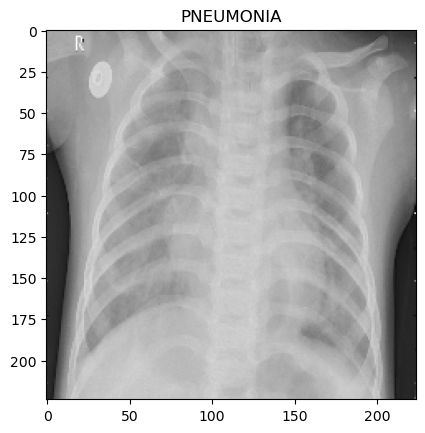

In [336]:
img, img_label, rand_img_num = select_random_image(split_data, classes_data, split_set=0)
show_random_image(classes, classes_data, img, rand_img_num, split_set=0)

In [337]:
# test them in succession

#img = np.ones((6, 6, 1))

# index = 0
# for k in range(0,img.shape[0]):
#     for h in range(0,img.shape[1]):
#         img[k, h] = index
#         index += 1

print(img.shape)
img = reshape_img(img)
print(img.shape)

c1 = conv_layer(in_dim=img.shape, conv_size=(3,3), kernel_num=2)
a1 = activation_layer(in_dim=c1.get_out_dim())
p1 = max_pooling_layer(in_dim=c1.get_out_dim(), pooling_size=(3,3))
f1 = fully_connected_layer(in_dim=p1.get_out_dim(), out_dim=10)
sm1 = softmax_layer(in_dim=f1.get_out_dim())
print("before cnn")
print(img)
k = c1.forward(img)
print("after conv forward")
print(k)
k = a1.forward(k)
print("after activation forward")
print(k)
k = p1.forward(k)
print("after pooling forward")
print(k)
k = f1.forward(k)
print("after fully connected forward")
print(k)
k = sm1.forward(k)
print("after softmax forward")
print(k)
k = sm1.backward(k, img_label)
print("after softmax backward")
print(k)

(224, 224)
(224, 224, 1)
before cnn
[[[162]
  [164]
  [164]
  ...
  [ 49]
  [ 52]
  [ 49]]

 [[160]
  [162]
  [168]
  ...
  [ 52]
  [ 52]
  [ 52]]

 [[162]
  [164]
  [168]
  ...
  [ 51]
  [ 49]
  [ 50]]

 ...

 [[ 43]
  [ 42]
  [ 42]
  ...
  [ 40]
  [ 36]
  [ 55]]

 [[ 43]
  [ 41]
  [ 41]
  ...
  [ 40]
  [ 36]
  [ 69]]

 [[ 42]
  [ 41]
  [ 40]
  ...
  [ 40]
  [ 42]
  [114]]]
after conv forward
[[[-283.86504611  -26.23755111]
  [-288.69288316  -22.70460128]
  [-295.15372893  -35.00236   ]
  ...
  [ -91.88809643  -13.91990813]
  [ -87.80052742  -11.67120877]
  [ -89.65659077   -9.90283502]]

 [[-282.23718093  -25.17235232]
  [-291.16127291  -18.60968699]
  [-297.4656048   -18.91039184]
  ...
  [ -96.41015699   -8.97587094]
  [ -96.31058849   -9.50727127]
  [ -92.28324585  -10.58432167]]

 [[-286.00044281  -22.77312689]
  [-291.90214455  -23.79771074]
  [-299.34703714  -25.931829  ]
  ...
  [ -94.80443423  -11.81668297]
  [ -97.01011621  -12.84075568]
  [ -92.21125267  -18.43683234]]

 ..

### Test single layers

In [219]:
# test conv layer
a = np.zeros((6,6,2))
for w in range(0,a.shape[0], 2):
    for h in range(0,a.shape[1]):
        a[w, h, 0] = 1

for w in range(0,a.shape[0]):
    for h in range(0,a.shape[1], 2):
        a[w, h, 1] = 1

print("input before conv")
print(a[:,:,0])
print(a[:,:,1])
c = conv_layer(in_dim=a.shape, conv_size=(3,3), kernel_num=3)
print("expected out dim")
print(c.get_out_dim())
d = c.forward(a)
print("output conv shape")
print(d.shape)
print("output conv")
print(d[:,:,1])

input before conv
[[1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]]
[[1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]]
expected out dim
(4, 4, 3)
output conv shape
(4, 4, 3)
output conv
[[-1.52193024 -0.89781454 -1.52193024 -0.89781454]
 [-0.16466416  0.45945153 -0.16466416  0.45945153]
 [-1.52193024 -0.89781454 -1.52193024 -0.89781454]
 [-0.16466416  0.45945153 -0.16466416  0.45945153]]


In [12]:
# test pool layer
a = np.zeros((7, 7, 3))
index = 0
for w in range(0,a.shape[0]):
    for h in range(0,a.shape[1]):
        a[w,h,:] = index
        index += 1
print("input before pool")
print(a[:,:,0])
c = max_pooling_layer(in_dim=a.shape, pooling_size=(3,3))
d = c.forward(a)
print("output pool")
print(d[:,:,0])

input before pool
[[ 0.  1.  2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11. 12. 13.]
 [14. 15. 16. 17. 18. 19. 20.]
 [21. 22. 23. 24. 25. 26. 27.]
 [28. 29. 30. 31. 32. 33. 34.]
 [35. 36. 37. 38. 39. 40. 41.]
 [42. 43. 44. 45. 46. 47. 48.]]
output pool
[[16. 19. 20.]
 [37. 40. 41.]
 [44. 47. 48.]]


In [14]:
# test activation layer
a = np.zeros((2, 3, 3))
index = -4
for k in range(0,a.shape[1]):
    for h in range(0,a.shape[2]):
        a[:, k, h] = index
        index += 1
print("input before activation")
print(a)
r = activation_layer(a.shape)
b = r.forward(a)
print(b)

input before activation
[[[-4. -3. -2.]
  [-1.  0.  1.]
  [ 2.  3.  4.]]

 [[-4. -3. -2.]
  [-1.  0.  1.]
  [ 2.  3.  4.]]]
[[[0. 0. 0.]
  [0. 0. 1.]
  [2. 3. 4.]]

 [[0. 0. 0.]
  [0. 0. 1.]
  [2. 3. 4.]]]


In [16]:
# test fully connected layer
a = np.ones((2, 3, 3))

print("input before fully connected")
print(a)
c = fully_connected_layer(in_dim=a.shape, out_dim=3)
d = c.forward(a)
print("output pool")
print(d)

input before fully connected
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
output pool
[18. 18. 18.]
